# Introdução

- Ambev
- KPI

# Inicialização

Carregamos a seguir as bibliotecas utilizadas.

In [1]:
# Import de bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pyxlsb import open_workbook as open_xlsb

import missingno as msno

%matplotlib inline

data_xlsb = '../data/ambev.xlsb'

In [2]:
# Executar se pyxlsb não tiver instalado
#!pip install pyxlsb
#from pyxlsb import open_workbook as open_xlsb

# Leitura/Limpeza dos dados

Incluímos aqui nessa seção os passos de tratamento do conjunto de dados realizados no notebook de exploração `AmBev_Data_Wrangling`. Algumas explicações são omitidas aqui, de modo a manter o notebook mais enxuto. Para mais detalhes sobre os passos realizados, favor consultar `AmBev_Data_Wrangling.ipynb`.

Definimos funções auxiliares para realizar a limpeza dos dados.

In [3]:
import unidecode

# Função para substituir espaços por _ (utilizado nos nomes de colunas)
def str_replace_spaces(input_str):
    if input_str == None: return None
    else: return input_str.replace(' ','_')

# Função para 'sanitizar' strings, substituindo erros inseridos por encoding
def str_sanitize(input_str):
    if not (isinstance(input_str,str)):
        return input_str
    
    output_str = input_str.replace('Á¡', 'á')
    
    return unidecode.unidecode(output_str)

# Função que recebe valores de uma linha 'suja' (com valores de Regra Alcance Parcial em mais de uma coluna) 
# e retorna uma linha 'limpa'.
def list_sanitize(input_list):
    output_list = []
    read_val = False
    
    for i, a in enumerate(input_list):
        if i == 21: 
            val = a
            if val != None: val = str(val)
        elif i == 22:
            if a != None \
            and not re.search('Sim',a) \
            and not re.search('Não',a):
                read_val = True
                val += " " + a
            else:
                output_list.append(val)
                output_list.append(a)
        
        else:
            if read_val:
                if a == None:
                    read_val = False
                    output_list.append(val)
                    output_list.append(a)
                    
                if re.search('\"$',str(a)):
                    read_val = False
                    val += " " + a
                    output_list.append(val)
                    
                    
            else:
                output_list.append(a)
                
    return output_list

Definidas as funções auxiliares, vamos realizar a leitura dos dados. Note que: valores ausentes são preenchidos com `nan`, para evitar valores `None` no dataframe; as últimas colunas (vazias) são removidas; e `Mes_Referencia` é tratado como `datetime`, no formato Mês + Ano.

In [4]:
df = []

with open_xlsb(data_xlsb) as wb:
    for sheetname in wb.sheets:
        with wb.get_sheet(sheetname) as sheet:  
            for i,row in enumerate(sheet.rows()):
                row_li = [item.v for item in row]
                if (i>0): row_li = list_sanitize(row_li)
                elif (i==0): row_li = [str_sanitize(str_replace_spaces(item)) for item in row_li]
                df.append(row_li)
                
df = pd.DataFrame(df[1:], columns=df[0])
df.drop(df.columns[-5:-1],axis=1,inplace=True)
df['Mes_Referencia'] = pd.to_datetime(df['Mes_Referencia'], format='%m%Y.0')
df['Banda'] = df['Banda'].apply(lambda x : str(x).upper() if (x != 'Blue Collars' and x != None) else x)

Vejamos como ficou o dataframe.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270633 entries, 0 to 270632
Data columns (total 33 columns):
Mes_Referencia           270633 non-null datetime64[ns]
Pais                     270633 non-null object
Mundo                    270501 non-null object
Regional/Area            270633 non-null float64
Unidade                  270633 non-null float64
Grupo_Cargo              230099 non-null object
Cargo                    262118 non-null object
Grade                    262118 non-null float64
Banda                    262118 non-null object
Area                     262116 non-null object
Nome_Funcionario         270633 non-null float64
Nome_Gestor              270633 non-null float64
Codigo_KPI               230229 non-null object
Diretoria                230229 non-null object
Areas_da_Diretoria       230229 non-null object
Funcao                   230229 non-null object
Tipo_da_Meta             270633 non-null object
Categoria_KPI            267176 non-null object
Nome_KPI    

Criamos um dicionário para substituir erros gerais na codificação, e definimos uma função para realizar a limpeza adicional.

In [6]:
replace_dict = {'Áµ':'õ',
                'Ã`\x01': 'Ê',
                'Ã\x8d': 'Í',
                'Ã! ':'Ç',
                'Ã\x92\x01O': 'ÃO',
                'Á\x1d ': 'Ô',
                'Á\x1c': 'Ó', 
                'Á\x8d': 'Í',
                'Â\xa0': ' ',
                '\x81':'',
                'â¬ \x1c ': '-', 
                'Á¡':'á',
                'Ã©': 'é',
                'Ã\xad': 'í',
                'Ã\x1c': 'Ó',
                'Ã£': 'ã',
                'ARMAZÁ0 M': 'ARMAZÉM',
                'OPERAçÁ" ES': 'OPERAçÕES',
                'Logisitca': 'Logistica',
                'Sumistros': 'Suministros',
                'GREG': 'GER'
               }

def str_clean(x):
    if x == None or not isinstance(x,str): return x
    for item in replace_dict:
        if item in x:
            x = x.replace(item,replace_dict[item])
            
    return unidecode.unidecode(x).strip()

Aplicamos a função aos campos que têm string. Além disso, usamos a função `title` para algumas categorias.

In [7]:
for col in df.columns:
    if (df[col].dtype=='O'):
        df[col] = df[col].apply(lambda x : str_clean(x))

cols = ['Grupo_Cargo', 'Area', 'Funcao', 'Categoria_KPI']
for col in cols:
    df[col] = df[col].apply(lambda x : x.title() if x != None else x)

Para refinar a limpeza, e remover inconsistências específicas a cada feature, aplicamos a função abaixo.

In [8]:
replace_dict_cat = {
    'Area': [
        ['E-Commerce', 'Ecommerce'],
        ['Projeto', 'Projetos']
    ],
    
    'Funcao': [
        ['Gerente Financeiro', 'Ger Financeiro']
    ],
    
    'Categoria_KPI': [
        ['Imagen De Mnarca', 'Imagen De Marca'],
        ['Machine Kpis', 'Machine Kpi'],
        ['Cash Flow','Cashflow'],
        ['Project Kpi', 'Project'],
        ['Le Accurancy', 'Le Accuracy'],
        ['Legal Compliance', 'Compliance'],
        ['Gestio N Recursos Marcas', 'Gestion Recursos Marcas']
        
    ],
    
    
    'Prazo': [
        ['monthly', 'Monthly'],
        ['Monthly basis', 'Monthly'],
        ['monthly basis', 'Monthly']
    ]
}

def str_refinement(df):
    for cat in replace_dict_cat:
        for [str_from,str_to] in replace_dict_cat[cat]:
            df[cat].replace(str_from,str_to,inplace=True)
            
str_refinement(df)

Agrupamos então strings similares dentro de uma mesma feature.

In [9]:
from difflib import SequenceMatcher

# Função de similaridade
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()    

# Função para agrupar as diferentes versões de strings em uma coluna
def str_similarity_replacement(df,col):
    replacement_dict = {}
    
    enum = list(enumerate(df[col].unique()))
    for i, a in enum:
        for j,b in enum:
            if (j > i) and (isinstance(a,str)) and (isinstance(b,str)) and (similar(a,b) > 0.7):
                if b not in replacement_dict: replacement_dict[b] = a
                
    for b in replacement_dict:
        a = replacement_dict[b]
        while (a in replacement_dict):
            a = replacement_dict[a]
        replacement_dict[b] = a
        
    for b in replacement_dict:
        df[col].replace(b, replacement_dict[b],inplace=True)
        
        
str_similarity_replacement(df,'Categoria_KPI')

O trabalho que não pôde ser realizado automaticamente pelo agrupamento é então realizado manualmente.

In [10]:
def sanitize_cat_kpi(df):
    col = 'Categoria_KPI'
    
    df[col] = df[col].apply(lambda x: re.sub(r'\s*/\s*', r'/', x).strip() if x != None else x)
    
    replace_dict = {
        'Continuous Improvement': 'Melhoria Continua',
        'People & Management': 'Gente E Gestao',
        'Imagem Da Marca (Brandhealth)': 'Imagem Da Marca',
        'Brand Health' : 'Imagem Da Marca',
        'Innovations/Innovations Project': 'Inovacoes/Projeto De Inovacoes',
        'Quality': 'Qualidade',
        'Imagen De Marca': 'Imagem Da Marca',
        'Rentabilidade/Custos (Maco, Vic, Vlc, Ebitda, Eficiencia E Produtividade)': 'Rentabilidade/Custos',
        'Rentabilidad/Costos': 'Rentabilidade/Custos',
        'Better World' : 'Mundo Melhor',
        'Innovaciones': 'Inovacoes/Projeto De Inovacoes',
        'Profit/Costs (Maco,Vic, Vlc, Ebitda..)': 'Rentabilidade/Custos',
        'Long-Term Projects/Initiatives/Strategy': 'Projetos/Iniciativas De Longo Prazo/Estrategia',
        'Volumen': 'Market Share/Volume',
        'Ebitda': 'Rentabilidade/Custos',
        'Productivity': 'Rentabilidade/Custos',
        'Cost': 'Rentabilidade/Custos',
        'Gestion': 'Gente E Gestao',
        'Sinergias Caribe': 'Sinergias',
        'Synergies': 'Sinergias',
        'People': 'Gente E Gestao',
        'Reputacion': 'Imagem Da Marca',
        'Project': 'Projetos/Iniciativas De Longo Prazo/Estrategia',
        'Safety': 'Seguranca',
        'Seguridad': 'Seguranca',
        'Obz': 'OBZ',
        'Zbb': 'OBZ',
        'Obz Incentivos': 'OBZ',
        'Reporte De Carga Tendencias Obz': 'OBZ',
        'Vpo Sustentable - Management And People Pilar': 'Gente E Gestao',
        'Dpo': 'DPO',
        'Machine Kpi': 'Machine KPI',
        'Rojo+Negro Equipo Frio': 'Equipo Frio',
        'Reporte Equipo Frio Rojo+Negro': 'Equipo Frio',
        'Asistente De Nomica': 'Cashflow',
        'Cumplimiento': 'Compliance'
    }
    
    for a in replace_dict:
        df[col].replace(a, replace_dict[a], inplace=True)
    
    
    
    
sanitize_cat_kpi(df)

In [11]:
df.fillna(value=pd.np.nan, inplace=True)
df.replace('None', np.nan, inplace=True)

In [12]:
df.head()

,Mes_Referencia,Pais,Mundo,Regional/Area,Unidade,Grupo_Cargo,Cargo,Grade,Banda,Area,...,%_Ating_Mes,%_Pontos_Mes,%_Acum_Mes,%_Ating_Acumulado,%_Pontos_Acumulado,%_Acum_Acumulado,%_Ating_Fim_Exer,%_Pontos_Fim_Exer,%_Acum_Fim_Exer,Status_Meta
0,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,25.0,Monitoramento Aprovado
1,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,80.0,60.0,12.0,80.0,60.0,12.0,100.0,100.0,20.0,Monitoramento Aprovado
3,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,100.0,100.0,15.0,90.0,80.0,12.0,100.0,100.0,15.0,Monitoramento Aprovado
4,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Aqui se encerra a etapa de Limpeza/Manipulação dos dados feita anteriormente. A seguir, dividimos as colunas em classes, de modo a facilitar a exploração.

In [13]:
# Variáveis categóricas
category = [
    'Pais',
    'Mundo',
    'Grupo_Cargo',
    'Cargo',
    'Nome_Funcionario',
    'Nome_Gestor',
    'Codigo_KPI',
    'Diretoria',
    'Areas_da_Diretoria',
    'Funcao',
    'Tipo_da_Meta',
    'Categoria_KPI',
    'Nome_KPI',
    'Meta_Projeto',
    'Status_Meta'
]

# Variáveis binárias
binary = [    
]

# Variáveis numéricas de valor inteiro
integral = [
    'Regional/Area',
    'Grade',
    'Peso_KPI',
    'Unidade',
    '%_Ating_Mes', 
    '%_Pontos_Mes', 
    '%_Acum_Mes', 
    '%_Ating_Acumulado', 
    '%_Pontos_Acumulado', 
    '%_Acum_Acumulado', 
    '%_Ating_Fim_Exer', 
    '%_Pontos_Fim_Exer', 
    '%_Acum_Fim_Exer'
]

# Variáveis numéricas de valor contínuo
continuous = [
]

# Demais tipos de variáveis
timestamp = ['Mes_Referencia','Prazo']
rule = ['Regra_Alcance_Parcial']

# Convertemos as categorias
df[category] = df[category].astype('category')

# Convertemos os valores inteiros
# Por limitação do Pandas/Numpy, valores inteiros tratados como float devido à presença de NaN
integral_as_int = []
integral_as_float = []

for col in integral:
    if not (df[col].isnull().values.any()):
        df[col] = df[col].astype('int')
        integral_as_int.append(col)
    else:
        df[col] = df[col].astype('float')
        integral_as_float.append(col)


# Exploração dos dados

Iniciamos aqui a Análise Exploratória dos Dados (ou EDA - *Exploratory Data Analysis*), a fim de tentar obter *insights* sobre os dados e as distribuições.

Usaremos a função auxiliar a seguir, que, para uma dada coluna, nos exibe, para as colunas com poucos valores únicos, quais valores destas aparecem somente nos casos em que a coluna de entrada possui valores ausentes e quais aparecem no caso contrário. Definimos ainda uma função similar, a ser utilizada posteriormente, para ver comportamento das features caso uma dada coluna tenho um valor específico.

In [128]:
# Função para imprimir, dada coluna col_na e dataframe df, quais valores únicos aparecem quando col_na é NaN 
# e quais aparecem quando col_na não é, dentre as colunas com no máximo 'limit' (padrão 100) valores únicos
def evaluate_missing_df(df,col_na,limit=100):
    for col in df.columns:
        if (df[col].nunique() < limit):
            na_set = set(df[df[col_na].isna()][col].unique().tolist())
            non_na_set = set(df[~df[col_na].isna()][col].unique().tolist())
            print('*** ' + col)
            print('* NA only')
            print(na_set.difference(non_na_set))
            print('* Non-NA only')
            print(non_na_set.difference(na_set))
            print()
            
def evaluate_col_val_df(df,col_eval,val,limit=100):
    for col in df.columns:
        if (df[col].nunique() < limit):
            val_set = set(df[df[col_eval]==val][col].unique().tolist())
            non_val_set = set(df[df[col_eval]!=val][col].unique().tolist())
            print('*** ' + col)
            print('* col == val only')
            print(val_set.difference(non_val_set))
            print('* col != val only')
            print(non_val_set.difference(val_set))
            print()

## Estatísticas básicas

Vamos começar analisando algumas características mais básicas do conjunto de dados.

TODO
- Definir target
- Escrever intro
- Criar feat baseada em Mundo

### Valores únicos

Vemos aqui o número de valores únicos em features com até 50 valores únicos. Algumas, como `Status_Meta`, `Meta_Projeto`, e as categorias de porcentagem (iniciando com '%') possuem poucos valores únicos (menos de 5 cada uma).

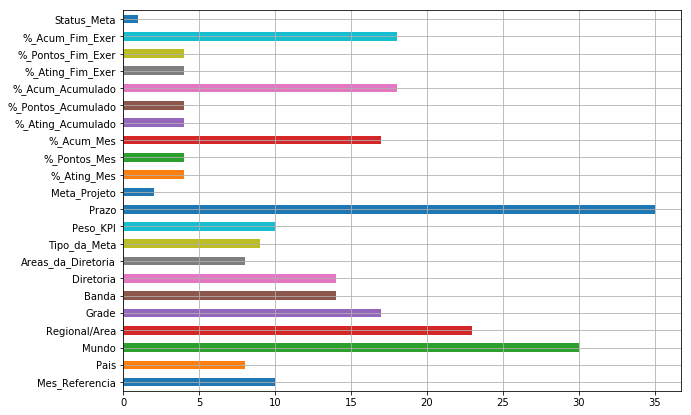

In [14]:
plt.figure(figsize=(10,7))
(df.loc[:, df.apply(lambda x: x.nunique()) < 50]).nunique().plot(kind='barh')
plt.grid()

### Categorias

Vejamos então a distribuição em algumas das principais categorias. Escolhemos aqui as que imaginamos serem mais intuitivas para iniciar a exploração.

#### País

Text(0.5, 0, 'Quantidade de pessoas alocadas')

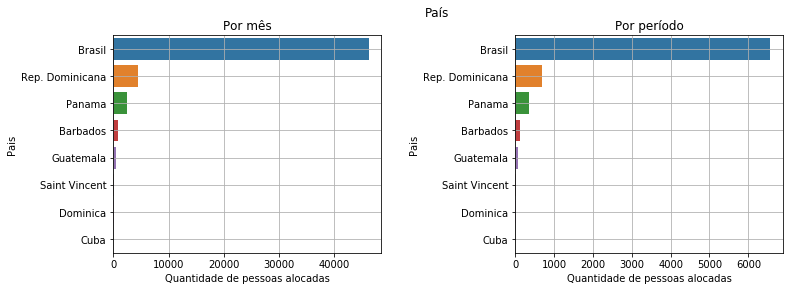

In [15]:
to_plot = 'Pais'
fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('País')

ax = fig.add_subplot(1, 2, 1)
ax.title.set_text('Por mês')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Por período')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

#### Mundo

Text(0.5, 0, 'Quantidade de pessoas alocadas')

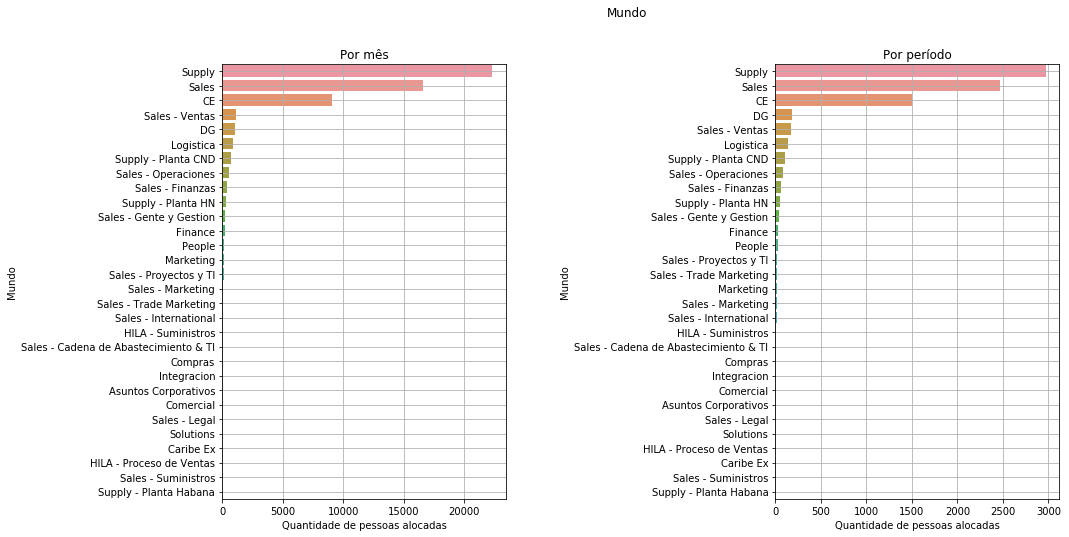

In [16]:
to_plot = 'Mundo'
fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(hspace=0.5, wspace=0.95)
fig.suptitle('Mundo')

ax = fig.add_subplot(1, 2, 1)
ax.title.set_text('Por mês')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Por período')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

#### Banda

Text(0.5, 0, 'Quantidade de pessoas alocadas')

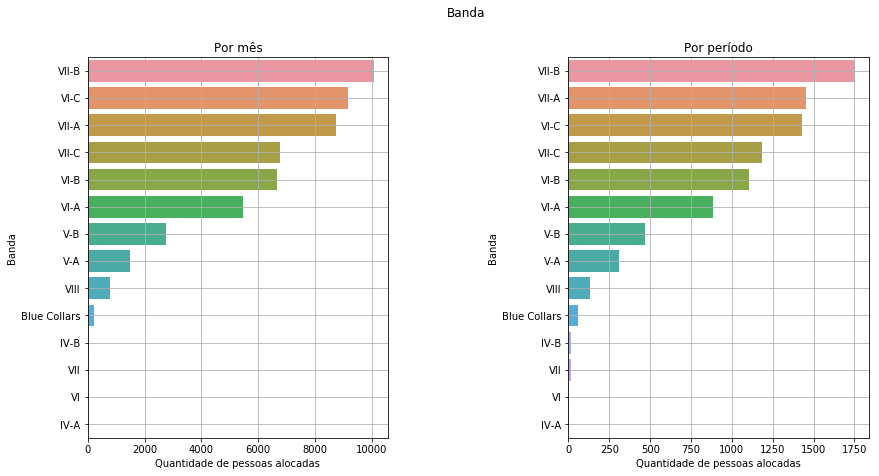

In [17]:
to_plot = 'Banda'
fig = plt.figure(figsize=(14,7))
fig.subplots_adjust(hspace=0.5, wspace=0.6)
fig.suptitle('Banda')

ax = fig.add_subplot(1, 2, 1)
ax.title.set_text('Por mês')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Por período')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')


#### Tipo da Meta

Text(0.5, 0, 'Quantidade de pessoas alocadas')

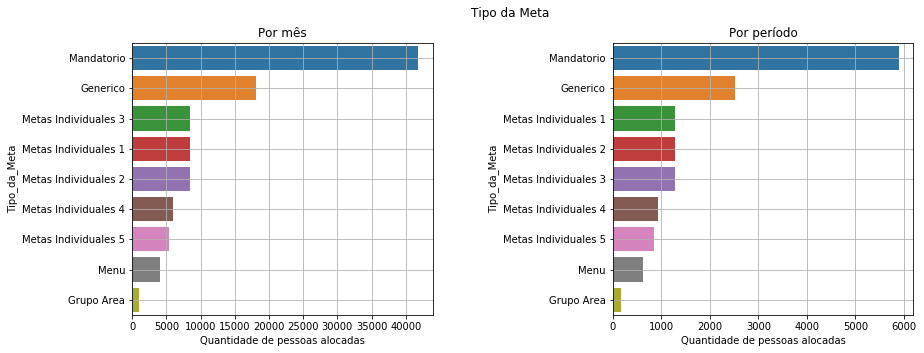

In [156]:
to_plot = 'Tipo_da_Meta'
fig = plt.figure(figsize=(14,5))
fig.subplots_adjust(hspace=0.5, wspace=0.6)
fig.suptitle('Tipo da Meta')

ax = fig.add_subplot(1, 2, 1)
ax.title.set_text('Por mês')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Por período')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

#### Status Meta

A seguir, podemos observar que o único valor de `Status_Meta`, 'Monitoramento Aprovado', só foi preenchido em pouco menos de 40% das entradas, isto é, mais de 60% dos valores da coluna não foram preenchidos.

Text(0.5, 0, 'Quantidade')

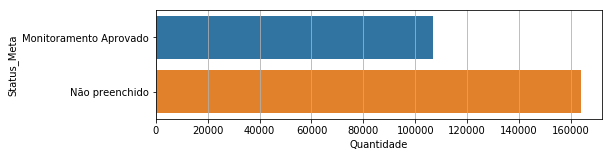

In [21]:
plt.figure(figsize=(8,2.0))
plt.grid()
meta_nan = 'Não preenchido'
df['Status_Meta'] = df['Status_Meta'].cat.add_categories(meta_nan)

sns.countplot(y=df['Status_Meta'].fillna(meta_nan))
plt.xlabel('Quantidade')

In [22]:
len(df[df['Status_Meta'].isna()])/len(df)*100

60.56947970129289

## Valores ausentes

Vamos observar então a distribuição de valores ausentes nas colunas, outra característica importante para entender os dados.

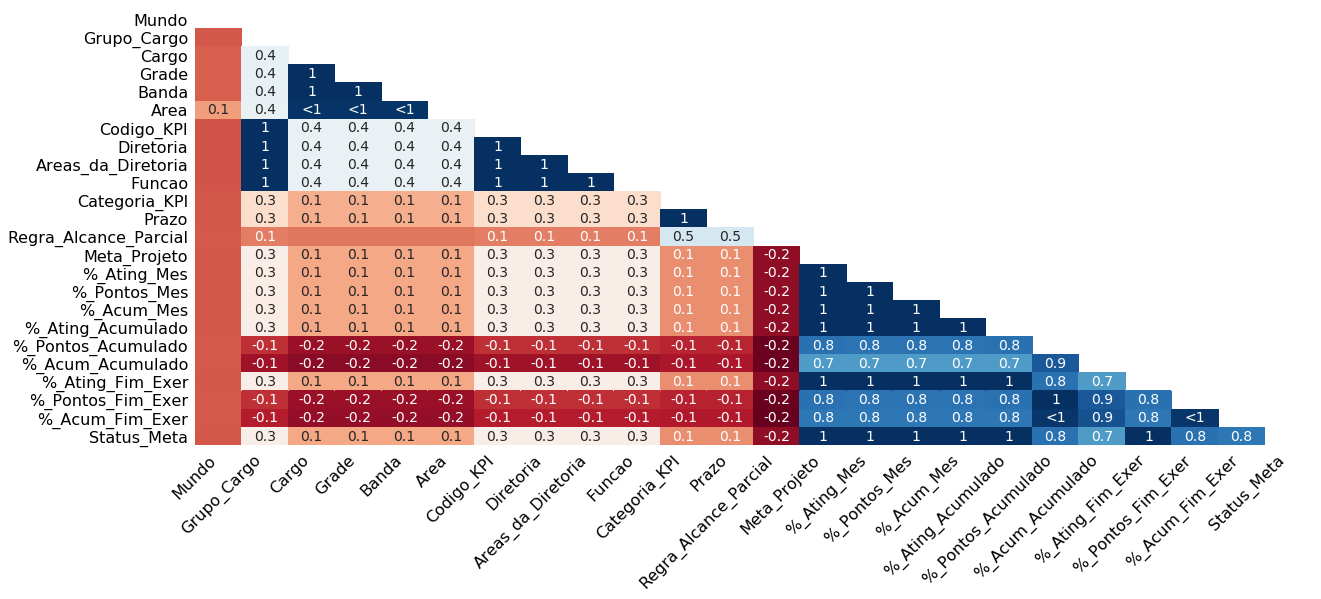

In [19]:
msno.heatmap(df,figsize=(20,8))

Além da alta correlação entre os valores não preenchidos nas categorias de porcentagem, notamos uma alta correlação entre estes com as colunas `Meta_Projeto` e `Status_Meta`, o que pode indicar:

- Uma inadequação de alguns setores com o sistema de monitoramento de metas; ou
- A ausência de necessidade de metas por serem áreas com objetivos pouco mensuráveis.

É importante discernir os casos, e que a companhia saiba destes, principalmente em se tratando do primeiro.

É possível notar ainda uma alta correlação entre os valores ausentes de `Grupo Cargo`, `Diretoria`, `Áreas da Diretoria` e `Código KPI`; e entre `Cargo`, `Grade`, `Área` e `Cargo`.

Vamos investigar essa features a seguir. 

### `Status Meta` e `Meta Projeto` 

Da análise das features `Status Meta` e `Meta Projeto`, podemos observar que os valores nulos se concentram na 'Regional/Area' de número 4. É importante que este fato seja conhecido, para que sejam tomadas as atitudes necessárias.

In [34]:
evaluate_missing_df(df,'Status_Meta')

*** Mes_Referencia
* NA only
set()
* Non-NA only
set()

*** Pais
* NA only
{'Panama', 'Barbados', 'Cuba', 'Saint Vincent', 'Guatemala', 'Dominica', 'Rep. Dominicana'}
* Non-NA only
set()

*** Mundo
* NA only
{'Solutions', 'Sales - Trade Marketing', 'Finance', 'HILA - Suministros', 'People', 'Sales - Proyectos y TI', 'Supply - Planta CND', 'Sales - Marketing', 'Sales - Ventas', 'Sales - Operaciones', 'HILA - Proceso de Ventas', 'Asuntos Corporativos', 'Sales - Suministros', 'Comercial', 'Marketing', 'Sales - Finanzas', 'Sales - Legal', 'Logistica', 'Sales - International', 'Sales - Gente y Gestion', 'Sales - Cadena de Abastecimiento & TI', 'Caribe Ex', 'Supply - Planta HN', 'Supply - Planta Habana', 'Integracion', 'Compras'}
* Non-NA only
set()

*** Regional/Area
* NA only
{4}
* Non-NA only
set()

*** Grade
* NA only
{nan, 1.0, 2.0, 3.0, 4.0, 5.0, 17.0}
* Non-NA only
{nan}

*** Banda
* NA only
{'IV-A', 'Blue Collars', 'VI', 'VII'}
* Non-NA only
set()

*** Diretoria
* NA only
{nan}
* Non

In [158]:
evaluate_missing_df(df,'Meta_Projeto')

*** Mes_Referencia
* NA only
set()
* Non-NA only
set()

*** Pais
* NA only
{'Panama', 'Barbados', 'Cuba', 'Saint Vincent', 'Guatemala', 'Dominica', 'Rep. Dominicana'}
* Non-NA only
set()

*** Mundo
* NA only
{'Solutions', 'Sales - Trade Marketing', 'Finance', 'HILA - Suministros', 'People', 'Sales - Proyectos y TI', 'Supply - Planta CND', 'Sales - Marketing', 'Sales - Ventas', 'Sales - Operaciones', 'HILA - Proceso de Ventas', 'Asuntos Corporativos', 'Sales - Suministros', 'Comercial', 'Marketing', 'Sales - Finanzas', 'Sales - Legal', 'Logistica', 'Sales - International', 'Sales - Gente y Gestion', 'Sales - Cadena de Abastecimiento & TI', 'Caribe Ex', 'Supply - Planta HN', 'Supply - Planta Habana', 'Integracion', 'Compras'}
* Non-NA only
set()

*** Regional/Area
* NA only
{4}
* Non-NA only
set()

*** Grade
* NA only
{nan, 1.0, 2.0, 3.0, 4.0, 5.0, 17.0}
* Non-NA only
{nan}

*** Banda
* NA only
{'IV-A', 'Blue Collars', 'VI', 'VII'}
* Non-NA only
set()

*** Diretoria
* NA only
{nan}
* Non

### `Categoria KPI`

Analisando as entradas que não possuem valores na feature `Categoria_KPI`, percebemos que todos se concentram também na 'Regional/Area' de número 4, além do fato de que nestes casos as colunas de porcentagens de pontos relacionadas a metas de KPI só possuem valores 0 ou não foram preenchidas.
Vejamos então as proporções com que cada Regional deixou de preencher dados de KPI.

In [182]:
for col in df.columns:
    print(col)
    print(df[df['Categoria_KPI'].isna()][col].unique())

Mes_Referencia
['2017-06-01T00:00:00.000000000' '2017-07-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2017-09-01T00:00:00.000000000'
 '2017-10-01T00:00:00.000000000' '2017-11-01T00:00:00.000000000'
 '2017-12-01T00:00:00.000000000']
Pais
[Barbados, Cuba, Dominica, Guatemala, Panama, Rep. Dominicana]
Categories (6, object): [Barbados, Cuba, Dominica, Guatemala, Panama, Rep. Dominicana]
Mundo
[Supply, Sales, Finance, Integracion, Marketing, ..., Sales - Proyectos y TI, Sales - Suministros, Sales - Trade Marketing, Supply - Planta CND, Asuntos Corporativos]
Length: 24
Categories (24, object): [Supply, Sales, Finance, Integracion, ..., Sales - Suministros, Sales - Trade Marketing, Supply - Planta CND, Asuntos Corporativos]
Regional/Area
[4]
Unidade
[ 16  17 257 279 264 258 305 306 315 328 329  47  50  56  69 113 147 159
 160 161 165 265 290 292 312 325 316]
Grupo_Cargo
[NaN]
Categories (0, object): []
Cargo
[NaN, GER DE TRADE MKTG ROTA III, COORDENADOR JR, ANALISTA II, ESPECIALI

Text(0, 0.5, 'Regional/Area')

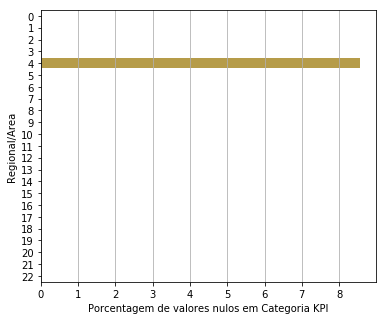

In [25]:
vals = []
for a in sorted(df['Regional/Area'].unique()):
    vals.append([a,100*len(df[df['Categoria_KPI'].isna() & (df['Regional/Area']==a)])/len(df[(df['Regional/Area']==a)])])
    
plt.figure(figsize=(6,5))
plt.grid()
sns.barplot(y=[i[0] for i in vals], x=[i[1] for i in vals], orient="h")
plt.xlabel("Porcentagem de valores nulos em Categoria KPI")
plt.ylabel("Regional/Area")

A partir do gráfico, vemos que todas Áreas preencheram integralmente os valores de Categoria de KPI, exceto pela 4. Esta deixou de fazê-lo em pouco mais de 8% das entradas fornecidas.

Analisamos então a proporção com que a mesma área deixou de incluir dados em algumas colunas. Além das já discutidas, vale notar que `Cargo` e `Grade` não foram preenchidas em cerca de 20% dos casos.

Text(0, 0.5, 'Coluna')

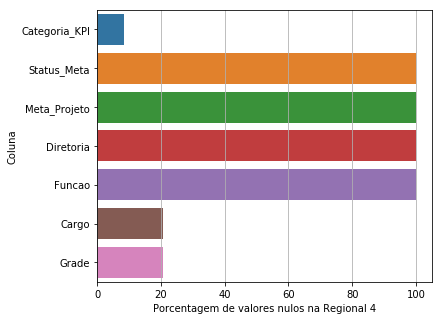

In [185]:
vals = []
for a in ['Categoria_KPI','Status_Meta','Meta_Projeto', 'Diretoria', 'Funcao', 'Cargo', 'Grade']:
    vals.append([a,100*len(df[df[a].isna() & (df['Regional/Area']==4)])/len(df[(df['Regional/Area']==4)])])
    
plt.figure(figsize=(6,5))
plt.grid()
sns.barplot(y=[i[0] for i in vals], x=[i[1] for i in vals], orient="h")
plt.xlabel("Porcentagem de valores nulos na Regional 4")
plt.ylabel("Coluna")

## KPI

Vamos então analisar mais a fundo os dados de KPI.

### Principais categorias

Vamos analisar aqui as principais categorias de KPI no dataframe. Estas serão armazenadas para análise futura.

In [47]:
# Operações a serem realizadas
oper = ['mean', 'std']

# Colunas a serem agrupadas
kpi_cols = {'Peso_KPI' : oper + ['count']} 
for col in df.columns:
    if re.search('^%_',col):
        kpi_cols[col] = oper

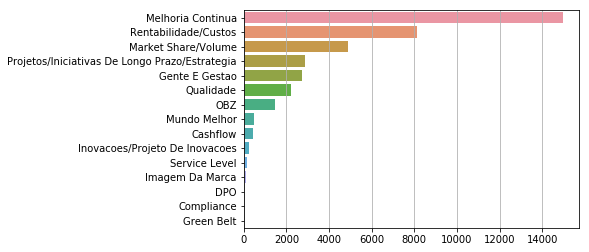

In [116]:
# Criamos então o dataframe agregando as features por categoria        
agg_df = df[~df['Categoria_KPI'].isna()].\
        drop_duplicates(['Nome_Funcionario', 'Codigo_KPI']).groupby('Categoria_KPI').\
                        agg(kpi_cols)
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]

plt.grid()
sns.barplot(x=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].values.tolist(), 
            y=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].index.values.tolist())

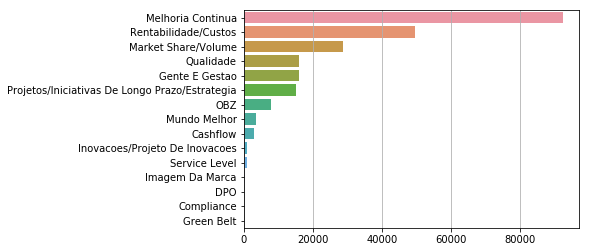

In [117]:
# Criamos outro dataframe, agregando as features por categoria, mas considerando também os meses    
agg_df = df[~df['Categoria_KPI'].isna()].\
        drop_duplicates(['Nome_Funcionario', 'Mes_Referencia', 'Codigo_KPI']).groupby('Categoria_KPI').\
                        agg(kpi_cols)
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]

plt.grid()
sns.barplot(x=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].values.tolist(), 
            y=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].index.values.tolist())

In [60]:
main_kpi_cats = agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'].index.tolist()[:10]

### Porcentagens

Vamos analisar então as relações e as distribuições das categorias de porcentagem (iniciando com '%'). Entendemos que estas se referem a pontuação no KPI e, portanto, são de grande importância.

A partir de observação dos dados fornecidos, concluímos:
- `Pontos` menor ou igual que `Ating`
- `Pontos` * `Peso_KPI`/100 = `Acum`

In [95]:
for period in ['Mes', 'Acumulado', 'Fim_Exer']:
    print(period)
    print('Relação 1: ' + str(df[df['%_Ating_' + period] < df['%_Pontos_' + period]].shape[0]))
    print('Relação 2: ' + str(df[df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period]].shape[0]))
    print('Relação 2 (Pontos não-nulo): ' + str(df[~df['%_Pontos_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print('Relação 2 (Acum não-nulo): ' + str(df[~df['%_Acum_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print('Relação 2 (Ambos não-nulos): ' + str(df[~df['%_Acum_'+period].isna() & ~df['%_Pontos_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print('Relação 2 (Ambos nulos): ' + str(df[df['%_Acum_'+period].isna() & df['%_Pontos_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print()

Mes
Relação 1: 0
Relação 2: 164348
Relação 2 (Pontos não-nulo): 0
Relação 2 (Acum não-nulo): 0
Relação 2 (Ambos não-nulos): 0
Relação 2 (Ambos nulos): 164348

Acumulado
Relação 1: 0
Relação 2: 152169
Relação 2 (Pontos não-nulo): 10933
Relação 2 (Acum não-nulo): 2189
Relação 2 (Ambos não-nulos): 0
Relação 2 (Ambos nulos): 139047

Fim_Exer
Relação 1: 0
Relação 2: 141215
Relação 2 (Pontos não-nulo): 0
Relação 2 (Acum não-nulo): 2168
Relação 2 (Ambos não-nulos): 0
Relação 2 (Ambos nulos): 139047



Note que a segunda observação não vale para todos valores de entrada, mas devido à presença de valores nulos. Usando a regra inferida, vamos recuperar estes valores.

In [187]:
mask = (~df['%_Pontos_Acumulado'].isna() & df['%_Acum_Acumulado'].isna())
df_valid = df[mask]

#df.loc[mask, '%_Acum_Acumulado'] = 
df_valid['%_Pontos_Acumulado'] * df_valid['Peso_KPI'] * 0.01

Series([], dtype: float64)

In [186]:
(df[~df['%_Pontos_Acumulado'].isna() & df['%_Acum_Acumulado'].isna()]['%_Pontos_Acumulado']*\
     df[~df['%_Pontos_Acumulado'].isna() & df['%_Acum_Acumulado'].isna()]['Peso_KPI'])

Series([], dtype: float64)

/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


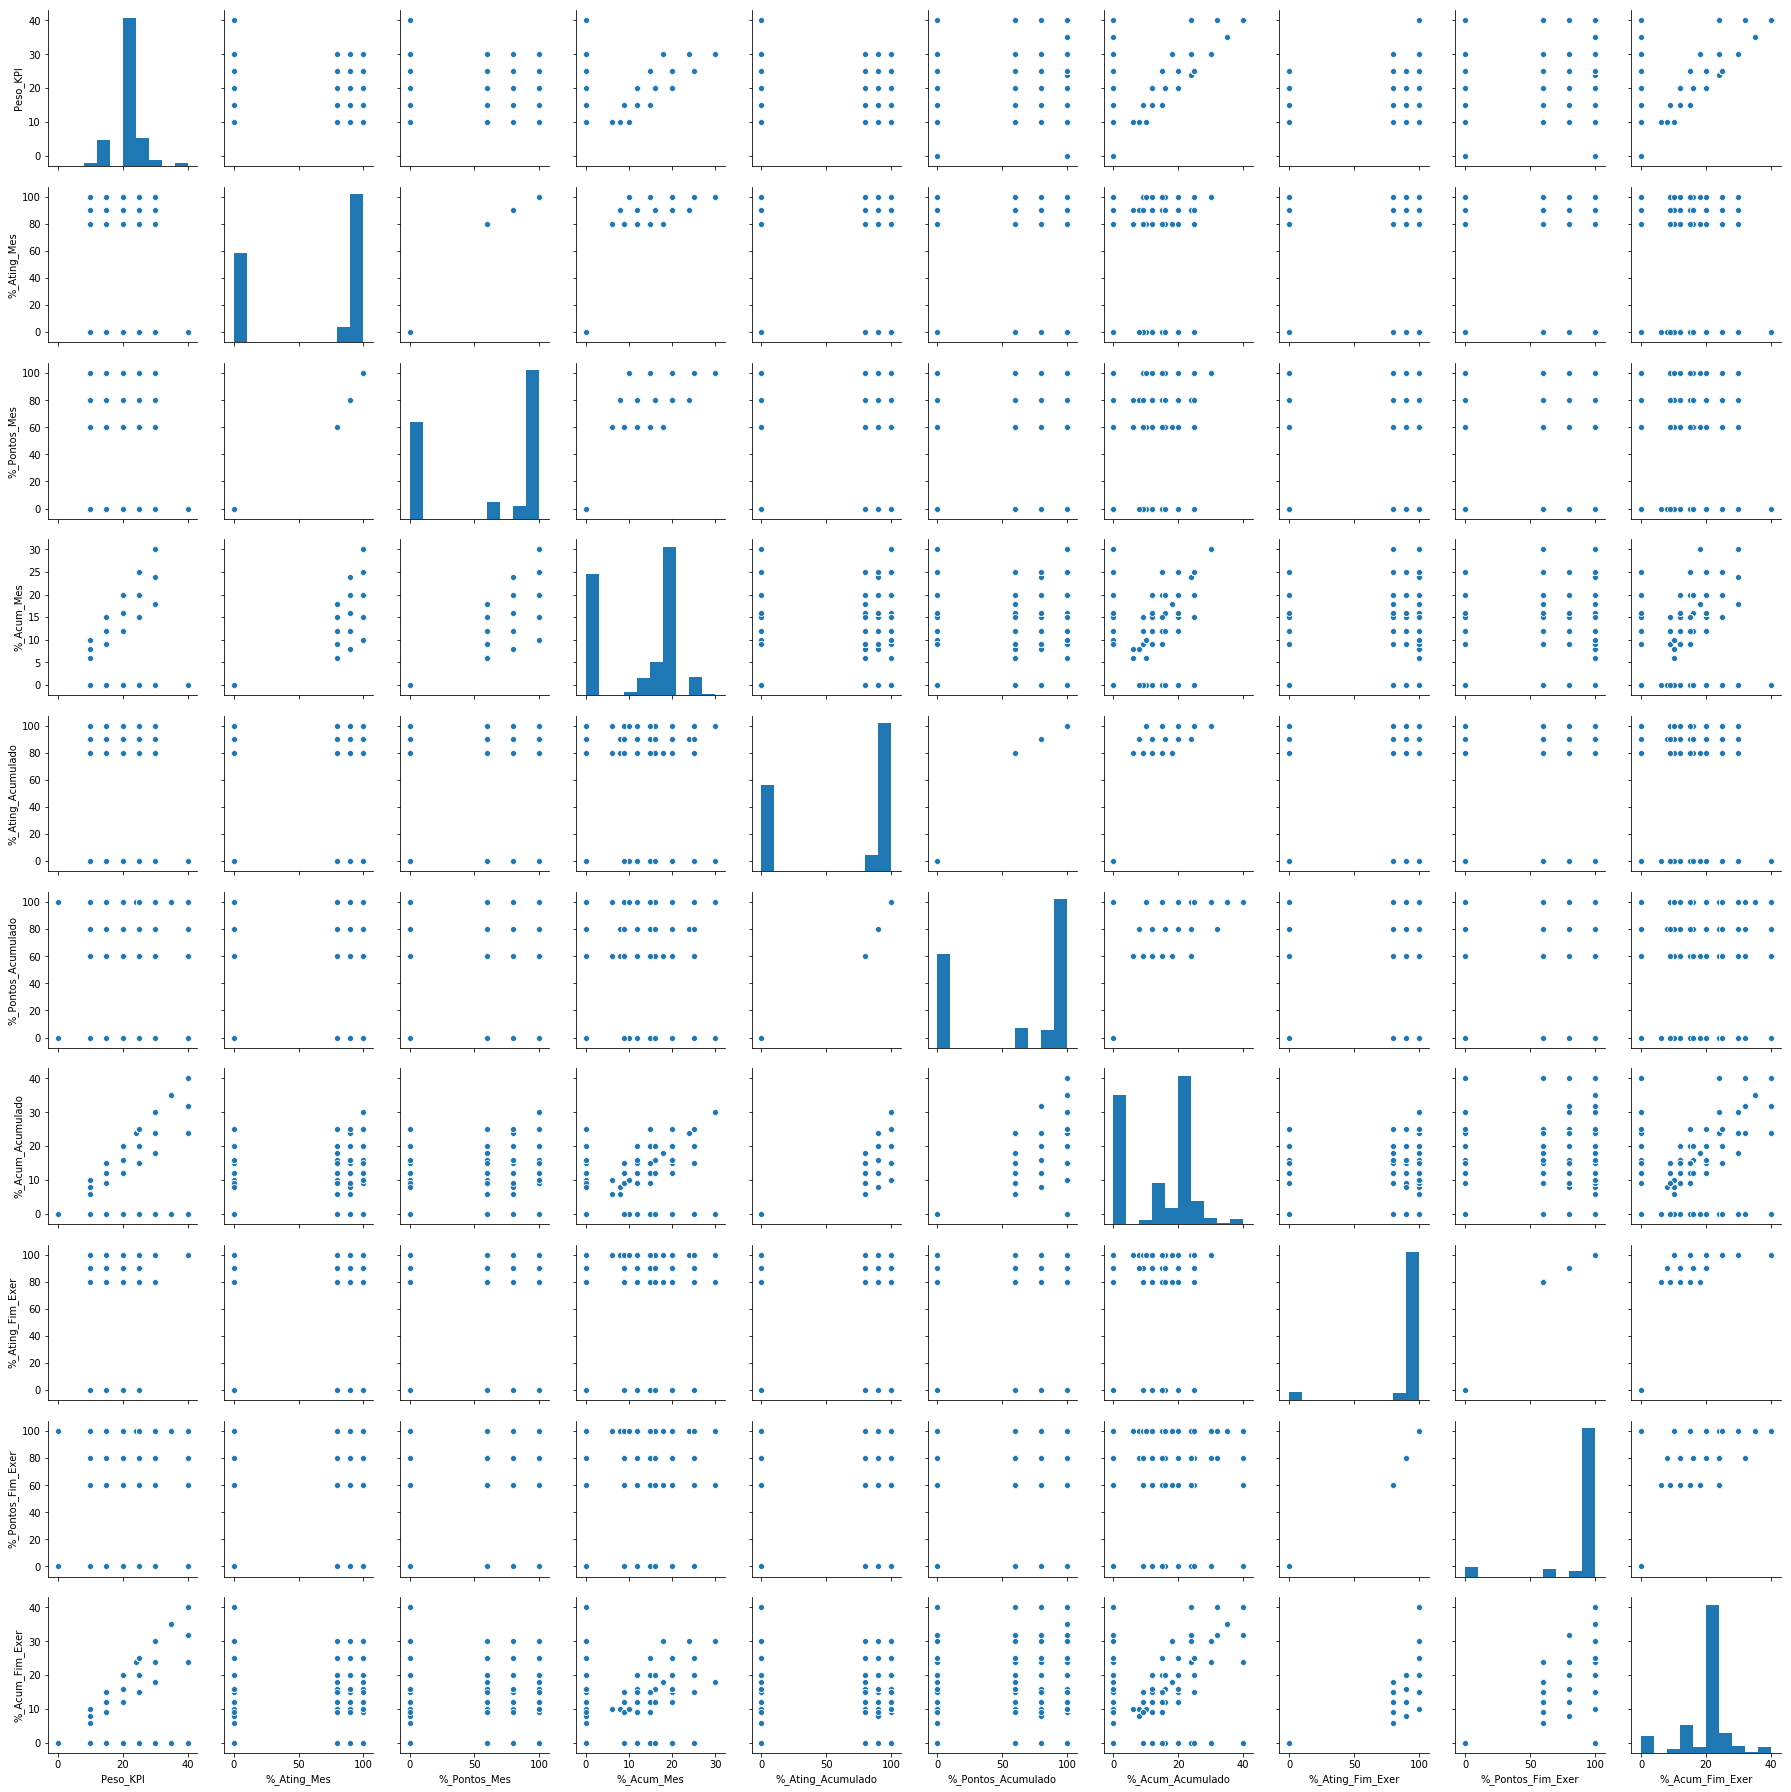

In [62]:
sns.pairplot(df[df['Categoria_KPI'].isin(main_kpi_cats)].\
        drop_duplicates(['Nome_Funcionario', 'Categoria_KPI'])[list(kpi_cols.keys())]);

Do gráfico acima, podemos observar:
- `Peso_KPI` e `%_Acum_Fim_Exer` seguem uma distribuição próxima de normal
- Todas as colunas com `Ating` ou `Pontos` no ínicio possuem maior concentração nos valores 0 ou 100, sendo que aquelas com final `Fim_Exer` possui quase todos os valores em 100
- As colunas iniciando com `Acum` parecem ter uma relação (próxima de) linear com `Peso_KPI`
- As colunas iniciando com `Acum` parecem estar correlacionadas entre si, sendo esta correlação menor para `%_Acum_Fim_Exer`

Alguns destes fatos podem ser observados no mapa de correlação a seguir.

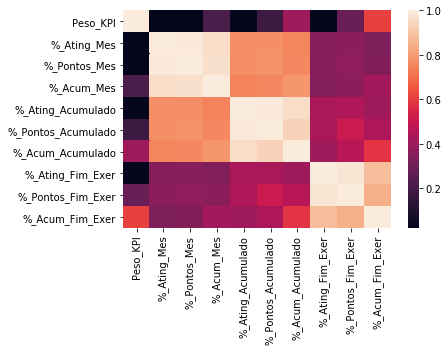

In [53]:
corr = df[list(kpi_cols.keys())].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Draft

Porcentagem de metas cumpridas integralmente.

In [103]:
for period in ['Mes', 'Acumulado', 'Fim_Exer']:
    print(period + ': ' + str((df[df['%_Ating_'+period] == df['%_Pontos_'+period]].shape[0]\
           /df[df['%_Ating_'+period] >= df['%_Pontos_'+period]].shape[0])*100))

Mes: 88.11873735710589
Acumulado: 86.43732663617962
Fim_Exer: 90.22977734462853


In [115]:
df[df['Nome_Funcionario']==2774][['Mes_Referencia', 'Categoria_KPI', 'Codigo_KPI'] + list(kpi_cols.keys())].head(10)

,Mes_Referencia,Categoria_KPI,Codigo_KPI,Peso_KPI,%_Ating_Mes,%_Pontos_Mes,%_Acum_Mes,%_Ating_Acumulado,%_Pontos_Acumulado,%_Acum_Acumulado,%_Ating_Fim_Exer,%_Pontos_Fim_Exer,%_Acum_Fim_Exer
0,2017-03-01,Market Share/Volume,001VA0561,25,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,25.0
1,2017-03-01,Market Share/Volume,001VA0609,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-03-01,Market Share/Volume,001TM0051,20,80.0,60.0,12.0,80.0,60.0,12.0,100.0,100.0,20.0
3,2017-03-01,Market Share/Volume,001VC0272,15,100.0,100.0,15.0,90.0,80.0,12.0,100.0,100.0,15.0
4,2017-03-01,Market Share/Volume,001RF0335,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20949,2017-04-01,Market Share/Volume,001VA0561,25,100.0,100.0,25.0,0.0,0.0,0.0,100.0,100.0,25.0
20950,2017-04-01,Market Share/Volume,001VA0609,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20951,2017-04-01,Market Share/Volume,001TM0051,20,80.0,60.0,12.0,80.0,60.0,12.0,100.0,100.0,20.0
20952,2017-04-01,Market Share/Volume,001VC0272,15,100.0,100.0,15.0,100.0,100.0,15.0,100.0,100.0,15.0
20953,2017-04-01,Market Share/Volume,001RF0335,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for m in list(df['Mes_Referencia'].unique()):
    print(m)
    print(df[df['Mes_Referencia']==m].shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.grid()
sns.lineplot(x="Mes_Referencia", y="Peso_KPI",
             #hue="region", style="event",
             data=df)

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x="Mes_Referencia", y="%_Pontos_Mes",
             #hue="region", style="event",
             data=df[~df['%_Pontos_Mes'].isna() & ~df['%_Ating_Mes'].isna() & ~df['%_Acum_Mes'].isna()])

sns.lineplot(x="Mes_Referencia", y="%_Pontos_Acumulado",
             #hue="region", style="event",
             data=df[~df['%_Pontos_Mes'].isna() & ~df['%_Pontos_Acumulado'].isna() & ~df['%_Pontos_Fim_Exer'].isna()])

sns.lineplot(x="Mes_Referencia", y="%_Pontos_Fim_Exer",
             #hue="region", style="event",
             data=df[~df['%_Pontos_Mes'].isna() & ~df['%_Pontos_Acumulado'].isna() & ~df['%_Pontos_Fim_Exer'].isna()])

plt.grid()
plt.xlabel('Mês')
plt.ylabel('Pontos')

# Draft

In [122]:
perc_cols = []
for col in df.columns:
    if re.search('^%_',col):
        perc_cols.append(col)
        
for a in perc_cols:
    print('* ' + a + ': ' + str(100*float(len(df[df[a].isna()]))/len(df)))
    for b in perc_cols:
        if (a!=b):
            print('*** ' + b + ': ' + str(100*float(len(df[~df[a].isna() & df[b].isna()]))/len(df[~df[a].isna()])))
            
    print()

* %_Ating_Mes: 60.72725794710919
*** %_Pontos_Mes: 0.0
*** %_Acum_Mes: 0.0
*** %_Ating_Acumulado: 0.0
*** %_Pontos_Acumulado: 0.0
*** %_Acum_Acumulado: 10.242273133556004
*** %_Ating_Fim_Exer: 0.0
*** %_Pontos_Fim_Exer: 0.0
*** %_Acum_Fim_Exer: 0.0

* %_Pontos_Mes: 60.72725794710919
*** %_Ating_Mes: 0.0
*** %_Acum_Mes: 0.0
*** %_Ating_Acumulado: 0.0
*** %_Pontos_Acumulado: 0.0
*** %_Acum_Acumulado: 10.242273133556004
*** %_Ating_Fim_Exer: 0.0
*** %_Pontos_Fim_Exer: 0.0
*** %_Acum_Fim_Exer: 0.0

* %_Acum_Mes: 60.72725794710919
*** %_Ating_Mes: 0.0
*** %_Pontos_Mes: 0.0
*** %_Ating_Acumulado: 0.0
*** %_Pontos_Acumulado: 0.0
*** %_Acum_Acumulado: 10.242273133556004
*** %_Ating_Fim_Exer: 0.0
*** %_Pontos_Fim_Exer: 0.0
*** %_Acum_Fim_Exer: 0.0

* %_Ating_Acumulado: 60.56947970129289
*** %_Ating_Mes: 0.40014243946322814
*** %_Pontos_Mes: 0.40014243946322814
*** %_Acum_Mes: 0.40014243946322814
*** %_Pontos_Acumulado: 0.0
*** %_Acum_Acumulado: 10.245333233375815
*** %_Ating_Fim_Exer: 0.0
*** %

In [138]:
'''
*** Status_Meta
* col == val only
{'Monitoramento Aprovado'}

*** Regional/Area
* col == val only
{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
* col != val only
{4}

*** Mundo
* col == val only
{nan, 'DG'}

*** Prazo
* col == val only
{42978.0, '3/31/2017 12:00:00 AM', 42916.0, 42825.0, '5/31/2017 12:00:00 AM', 42346.0, 
'12/31/2017 12:00:00 AM', '6/30/2017 12:00:00 AM', 42766.0, 42736.0, 43059.0, 42228.0, 
'1/31/2017 12:00:00 AM', '10/31/2017 12:00:00 AM', '1/30/1900 12:00:00 AM', 42747.0, 43039.0, 43070.0, 31.0}
* col != val only
{nan, 'monthly and quarterly basis', '30.06.2017', '31.07.2017', '31.12.2017', 
'30.09.2017', '30.11.17', '31.12.17', '30.08.2017', '30.12.2017', 'FY', '31.10.2017', 
'30.11.2017', 'TBD', 'July', 'Monthly'}

*** Meta_Projeto
* col == val only
{'Sim', 'Nao'}
* col != val only
set()
'''
evaluate_col_val_df(df,'Pais','Brasil')

*** Mes_Referencia
* col == val only
{1488326400000000000, 1491004800000000000, 1493596800000000000}
* col != val only
set()

*** Pais
* col == val only
{'Brasil'}
* col != val only
{'Panama', 'Barbados', 'Cuba', 'Saint Vincent', 'Guatemala', 'Dominica', 'Rep. Dominicana'}

*** Mundo
* col == val only
{nan, 'DG'}
* col != val only
{'Solutions', 'Sales - Trade Marketing', 'Finance', 'HILA - Suministros', 'People', 'Sales - Proyectos y TI', 'Supply - Planta CND', 'Sales - Marketing', 'Sales - Ventas', 'Sales - Operaciones', 'HILA - Proceso de Ventas', 'Asuntos Corporativos', 'Sales - Suministros', 'Comercial', 'Marketing', 'Sales - Finanzas', 'Sales - Legal', 'Logistica', 'Sales - International', 'Sales - Gente y Gestion', 'Sales - Cadena de Abastecimiento & TI', 'Caribe Ex', 'Supply - Planta HN', 'Supply - Planta Habana', 'Integracion', 'Compras'}

*** Regional/Area
* col == val only
{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
* col != val only
{4}

*

In [137]:
# checar quantidade de 'blue collar'
evaluate_col_val_df(df,'Regional/Area',4)

*** Mes_Referencia
* col == val only
set()
* col != val only
{1488326400000000000, 1491004800000000000, 1493596800000000000}

*** Pais
* col == val only
{'Panama', 'Barbados', 'Cuba', 'Saint Vincent', 'Guatemala', 'Dominica', 'Rep. Dominicana'}
* col != val only
{'Brasil'}

*** Mundo
* col == val only
{'Solutions', 'Sales - Trade Marketing', 'Finance', 'HILA - Suministros', 'People', 'Sales - Proyectos y TI', 'Supply - Planta CND', 'Sales - Marketing', 'Sales - Ventas', 'Sales - Operaciones', 'HILA - Proceso de Ventas', 'Asuntos Corporativos', 'Sales - Suministros', 'Comercial', 'Marketing', 'Sales - Finanzas', 'Sales - Legal', 'Logistica', 'Sales - International', 'Sales - Gente y Gestion', 'Sales - Cadena de Abastecimiento & TI', 'Caribe Ex', 'Supply - Planta HN', 'Supply - Planta Habana', 'Integracion', 'Compras'}
* col != val only
{nan, 'DG'}

*** Regional/Area
* col == val only
{4}
* col != val only
{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

*

In [160]:
evaluate_col_val_df(df,'Banda','VI')

*** Mes_Referencia
* col == val only
set()
* col != val only
{1488326400000000000, 1491004800000000000, 1504224000000000000, 1496275200000000000, 1493596800000000000}

*** Pais
* col == val only
set()
* col != val only
{'Panama', 'Barbados', 'Cuba', 'Guatemala', 'Brasil', 'Dominica'}

*** Mundo
* col == val only
set()
* col != val only
{nan, 'Solutions', 'Supply', 'Sales - Trade Marketing', 'Finance', 'CE', 'HILA - Suministros', 'People', 'Sales - Proyectos y TI', 'Supply - Planta CND', 'Sales - Marketing', 'Sales - Operaciones', 'HILA - Proceso de Ventas', 'Asuntos Corporativos', 'Sales - Suministros', 'Marketing', 'Sales - Finanzas', 'DG', 'Sales - Legal', 'Logistica', 'Sales', 'Sales - International', 'Sales - Gente y Gestion', 'Sales - Cadena de Abastecimiento & TI', 'Caribe Ex', 'Supply - Planta HN', 'Supply - Planta Habana', 'Integracion', 'Compras'}

*** Regional/Area
* col == val only
set()
* col != val only
{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20

In [161]:
df[df['Banda']=='VI']

,Mes_Referencia,Pais,Mundo,Regional/Area,Unidade,Grupo_Cargo,Cargo,Grade,Banda,Area,...,%_Ating_Mes,%_Pontos_Mes,%_Acum_Mes,%_Ating_Acumulado,%_Pontos_Acumulado,%_Acum_Acumulado,%_Ating_Fim_Exer,%_Pontos_Fim_Exer,%_Acum_Fim_Exer,Status_Meta
241607,2017-07-01,Saint Vincent,Comercial,4,327,NaN,GER DE TRADE MKTG ROTA III,13.0,VI,Comercial Rota,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241608,2017-07-01,Saint Vincent,Comercial,4,327,NaN,GER DE TRADE MKTG ROTA III,13.0,VI,Comercial Rota,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
241609,2017-07-01,Saint Vincent,Comercial,4,327,NaN,GER DE TRADE MKTG ROTA III,13.0,VI,Comercial Rota,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241610,2017-07-01,Saint Vincent,Comercial,4,327,NaN,GER DE TRADE MKTG ROTA III,13.0,VI,Comercial Rota,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241611,2017-07-01,Saint Vincent,Comercial,4,327,NaN,GER DE TRADE MKTG ROTA III,13.0,VI,Comercial Rota,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
244336,2017-08-01,Rep. Dominicana,Sales - Ventas,4,69,NaN,GER DE TRADE MKTG ROTA I,11.0,VI,Vendas Rota,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244337,2017-08-01,Rep. Dominicana,Sales - Ventas,4,69,NaN,GER DE TRADE MKTG ROTA I,11.0,VI,Vendas Rota,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244338,2017-08-01,Rep. Dominicana,Sales - Ventas,4,69,NaN,GER DE TRADE MKTG ROTA I,11.0,VI,Vendas Rota,...,NaN,NaN,NaN,NaN,80.0,16.0,NaN,80.0,16.0,NaN
244339,2017-08-01,Rep. Dominicana,Sales - Ventas,4,69,NaN,GER DE TRADE MKTG ROTA I,11.0,VI,Vendas Rota,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244340,2017-08-01,Rep. Dominicana,Sales - Ventas,4,69,NaN,GER DE TRADE MKTG ROTA I,11.0,VI,Vendas Rota,...,NaN,NaN,NaN,NaN,60.0,12.0,NaN,100.0,20.0,NaN
